## simplebaseline 모델로 변경해보자.
- 지금까지 StackedHourglass Network 기반으로 학습을 진행했다.
- 그러나 Simplebaseline 모델은 이보다 훨씬 간단한 모델 구조에도 불구하고 더욱 좋은 성능을 보여주었던 바가 있다.
- 실제로도 그런 성능을 얻을 수 있는지 확인해보자.
<br/><br/>
- step 1 : simplebaseline 모델 완성하기
- step 2 : simplebaseline 모델로 변경하여 훈련하기
- step 3 : 두 모델의 비교

### 라이브러리

In [ ]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
from tensorflow.keras.models import load_model
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle

- 고정해서 사용할 변수

In [ ]:
PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models_new')
LOSS_PATH = os.path.join(PROJECT_PATH, 'losses')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### JSON 파싱하기
- [데이터셋 : MPII Human Pose Dataset](http://human-pose.mpi-inf.mpg.de/#download)
- train.json, validation.json
    - 이미지에 담겨 있는 사람들의 pose keypoint 정보
    - pose estimation을 위한 label로 삼을 수 있음.
<br/><br/>
- json 구성 파악을 위해 1개만 출력
- json.dumps()를 활용해서 명확하게 표현

In [ ]:
# train_json 파일을 여고, json 형식의 annotation 정보를 읽어온다.
with open(TRAIN_JSON) as train_json:
    # json 파일을 python 데이터로 load한다.
    train_annos = json.load(train_json)

    # 1번째 annotation 정보를 예시로 선택하여 json 형식으로 출력
    # indent = 2 옵션은 들여쓰기를 2칸으로 지정하여 가독성을 높임
    json_formatted_str = json.dumps(train_annos[0], indent=2)

    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


- joints_vis
    - 이미지 형상과 사람의 포즈에 따라 모든 label이 이미지에 나타나지 않음
    - MPII = 1(visible), 0(non)
    - COCO = 2 / 1 / 0
<br/><br/>

- joints 순서
    - 0 - 오른쪽 발목
    - 1 - 오른쪽 무릎
    - 2 - 오른쪽 엉덩이
    - 3 - 왼쪽 엉덩이
    - 4 - 왼쪽 무릎
    - 5 - 왼쪽 발목
    - 6 - 골반
    - 7 - 가슴(흉부)
    - 8 - 목
    - 9 - 머리 위
    - 10 - 오른쪽 손목
    - 11 - 오른쪽 팔꿈치
    - 12 - 오른쪽 어깨
    - 13 - 왼쪽 어깨
    - 14 - 왼쪽 팔굼치
    - 15 - 왼쪽 손목
<br/><br/>

- scale
    - 사람의 크기 비율
    - 관절의 위치 및 사람의 신체 부분 크기를 상대적으로 표현
    - 이미지의 크기에 따라 상대적으로 바뀌는 값이기 때문에 이를 보정하기 위해 사용

- parse_one_annotation()
    - json annotation을 파싱하는 함수

In [ ]:
def parse_one_annotation(anno, image_dir):
    # annotation에서 필요한 정보 추출
    filename = anno['image']  # 이미지 파일명
    joints = anno['joints']  # 관절 좌표
    joints_visibility = anno['joints_vis']  # 관절 가시성 정보

    # 추출한 정보를 딕셔너리 형태로 구성
    annotation = {
        'filename': filename,  # 파일명
        'filepath': os.path.join(image_dir, filename),  # 이미지 파일의 전체 경로
        'joints_visibility': joints_visibility,  # 관절 가시성 정보
        'joints': joints,  # 관절 좌표
        'center': anno['center'],  # 이미지 상의 사람 중심 좌표
        'scale': anno['scale']  # 이미지 상의 사람 크기(scale)
    }

    # 구성된 딕셔너리를 반환
    return annotation

- 하나의 데이터에 parse_one_annotation()을 테스트

In [ ]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


### TFRcord 파일 만들기
- GPU보다 HDD I/O가 느리기 때문에 병목 현상 발생
- tf에서 변환을 자동화해주는 도구를 제공
- binary record sequence를 저장하기 위한 형식 (직렬화 데이터)
- annotation을 받아 하나의 tf.train.Example로 변환

- generate_tfexample()
    - annotation 정보를 이용하여 TFRecord에 저장할 Example을 생성
    1. 이미지 파일을 바이트로 읽어오고,
    2. 필요한 정보들을 TFRcord의 Feature로 구성
    3. TFRecord Example 객체를 생성하여 반환

In [ ]:
def generate_tfexample(anno):
    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    # annotation에서 필요한 정보 추출
    filename = anno['filename']
    filepath = anno['filepath']

    # 이미지 파일을 바이트로 읽어옴
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    # 이미지를 RGB 형식으로 변환 (JPEG 형식이 아니거나 모드가 RGB가 아닌 경우 변환)
    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    # 이미지의 너비, 높이, 채널 수 정보 추출
    width, height = image.size
    depth = 3

    # 사람 중심 좌표와 크기(scale) 정보 추출
    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    # 관절 좌표 및 가시성 정보 추출
    x = [int(joint[0]) if joint[0] >= 0 else int(joint[0]) for joint in anno['joints']]
    y = [int(joint[1]) if joint[1] >= 0 else int(joint[0]) for joint in anno['joints']]
    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    # TFRecord에 저장할 Feature들 구성
    feature = {
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth': tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x': tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y': tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale': tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v': tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded': _bytes_feature(content),
        'image/filename': _bytes_feature(filename.encode())
    }

    # TFRecord Example 객체 생성하여 반환
    return tf.train.Example(features=tf.train.Features(feature=feature))

- chunkify()
    - 여러 annotation에 대한 TFRecord를 얼마나 만들지 결정하는 함수

In [ ]:
def chunkify(l, n):
    # 리스트 l을 n개의 부분으로 나누는 함수
    # l: 나눌 리스트, n: 부분의 개수
    size = len(l) // n  # 부분의 크기 계산
    start = 0  # 시작 인덱스 초기화
    results = []  # 결과를 저장할 리스트

    # 부분의 개수(n)만큼 반복
    for i in range(n):
        # 리스트 l의 일부를 부분의 크기만큼 추출하여 results 리스트에 추가
        results.append(l[start:start + size])
        start += size  # 시작 인덱스 업데이트

    # 나눠진 부분들을 담은 리스트를 반환
    return results

- n개의 TFRcord 파일을 만들어 데이터 저장에도 용이하고 병렬 처리에도 이점이 있다.
- shard를 하는 이유
    - I/O 병목을 피하기 위해 입력 파일을 여러개로 나눈 뒤,
    - 병렬적으로 prefetch하는 것이 학습 속도를 빠르게 한다.
<br/><br/>
- chunkify() 함수를 테스트

In [ ]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

- 0이 1000개 들어있는 리스트가 64개 쪼개진다.
<br/><br/>
- build_single_tfrecord()
    - 단일 TFRecord 파일을 생성하는 역할
    - 하나의 annotation(chunk)에 대한 TFRecord Example을 생성
    - Ray를 사용하여 분산 환경에서 TFRecord 파일을 생성하는 함수

- build_tf_records()
    - 여러 개의 TFRecord 파일을 생성하는 역할
    - annotation 데이터를 여러 부분(chunks)으로 나누어 build_single_tfrecord 함수를 호출하여 TFRecord 파일 생성
    

In [ ]:
# ray : 병렬 처리를 위한 라이브러리
@ray.remote
def build_single_tfrecord(chunk, path):
    # 분산 환경에서 실행할 함수를 정의한뒤, @ray.remote annotation을 사용하여 Ray에 등록
    print('start to build tf records for ' + path)

    # TFRecord 파일을 쓰기 위한 TFRecordWriter 생성
    with tf.io.TFRecordWriter(path) as writer:
        # annotation(chunk)을 하나씩 가져와 TFRecord Example로 변환하고 파일에 쓰기
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    # TFRecord 파일 쓰기가 완료되면 완료 메시지 출력
    print('finished building tf records for ' + path)

In [ ]:
def build_tf_records(annotations, total_shards, split):
    # annotation을 total_shards 개수로 나누어 TFRecord 파일 생성 함수를 병렬로 실행
    chunks = chunkify(annotations, total_shards)

    # Ray를 사용하여 분산 처리를 위한 비동기 작업(futures) 생성
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]

    # 모든 비동기 작업이 완료될 때까지 대기
    ray.get(futures)

### TFRecord
- train 데이터는 64개
- val 데이터는 8개의 파일로 만든다.

In [ ]:
num_train_shards = 64
num_val_shards = 8

# 기존에 초기화된 Ray가 있다면 종료
#ray.shutdown()

# Ray 초기화
ray.init()

# TFRecord 경로 확인 및 생성
print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

# JSON 파일로부터 train 데이터와 validation 데이터의 annotation 읽기
with open(TRAIN_JSON) as train_json:
    # JSON 파일에서 train annotation 읽기
    train_annos = json.load(train_json)
    # 각 annotation을 파싱하여 필요한 정보 추출
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    # 첫 번째 train annotation 출력
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    # JSON 파일에서 validation annotation 읽기
    val_annos = json.load(val_json)
    # 각 annotation을 파싱하여 필요한 정보 추출
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in val_annos
    ]
    # 첫 번째 validation annotation 출력
    print('First val annotation: ', val_annotations[0])

# TFRecord 파일 생성
print('Start to build TF Records.')
# train 데이터에 대한 TFRecord 파일 생성
build_tf_records(train_annotations, num_train_shards, 'train')
# validation 데이터에 대한 TFRecord 파일 생성
build_tf_records(val_annotations, num_val_shards, 'val')

# TFRecord 파일 생성이 성공 여부 알림
print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2023-12-05 18:14:44,706	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.78gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

- 이미 Ray를 초기화했는데
- 또 다시 ray.init()을 호출하면 문제가 발생한다.
- 이미 초기화된 ray를 종료하고 다시 초기화해야한다.
- ray.shutdown()을 호출하여 ray를 종료한 후, ray.init()을 호출하면 된다.

---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
/tmp/ipykernel_31/2812350357.py in <module>
      3
      4 # Ray 초기화
----> 5 ray.init()
      6
      7 # TFRecord 경로 확인 및 생성

/opt/conda/lib/python3.9/site-packages/ray/_private/client_mode_hook.py in wrapper(*args, **kwargs)
     87             if func.__name__ != "init" or is_client_mode_enabled_by_default:
     88                 return getattr(ray, func.__name__)(*args, **kwargs)
---> 89         return func(*args, **kwargs)
     90
     91     return wrapper

/opt/conda/lib/python3.9/site-packages/ray/worker.py in init(address, num_cpus, num_gpus, resources, object_store_memory, local_mode, ignore_reinit_error, include_dashboard, dashboard_host, dashboard_port, job_config, configure_logging, logging_level, logging_format, log_to_driver, namespace, runtime_env, _enable_object_reconstruction, _redis_max_memory, _plasma_directory, _node_ip_address, _driver_object_store_memory, _memory, _redis_password, _temp_dir, _lru_evict, _metrics_export_port, _system_config, _tracing_startup_hook, **kwargs)
    838             return
    839         else:
--> 840             raise RuntimeError("Maybe you called ray.init twice by accident? "
    841                                "This error can be suppressed by passing in "
    842                                "'ignore_reinit_error=True' or by calling "

RuntimeError: Maybe you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

1. 각 이미지에 대한 annotation 읽기
    - JSON 파일로부터 읽은 annotation 정보를 이용
2. TFRecord 생성
    - 'build_tf_records', 'build_single_record' 함수를 사용하여 각 이미지에 대한 TFRecord 생성
3. Shard로 나누어 저장
    - 'num_train_shards'와 'num_val_shards'는 shard(작은 조각)의 개수를 나타낸다.

### Data label
- TFRecord로 저장된 데이터
    - 모델 학습에 필요한 데이터로 변환
    - TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 한다.
    - 데이터 형식도 같게 맞춰야 한다.

In [ ]:
def parse_tfexample(example):
    # TFRecord Example에서 추출할 Feature의 구조 정의
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }

    # TFRecord Example을 파싱하여 추출된 Feature들을 반환
    return tf.io.parse_single_example(example, image_feature_description)

- crop_roi()
    - 이미지를 적당히 정사각형으로 crop
    - 임의로 저장한 crop box가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다.

In [ ]:
def crop_roi(image, features, margin=0.2):
    # 이미지의 크기 정보 가져오기
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    # TFRecord Example에서 추출한 키포인트 및 중심 위치, 몸의 높이 정보 가져오기
    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # 유효한(visible = 1) 키포인트 값만 사용
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # 최소, 최대값 찾기
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용하여 x, y 위치 조정하여 정사각형 박스 생성
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지를 벗어나는 부분을 조정
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    # 새로운 이미지 추출
    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    # keypoint 위치 재조정
    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

(build_single_tfrecord pid=4967) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


- (x, y) 좌표 keypoint를 heatmap으로 변경
- 좌표 근처 여러 지점에 확률 분포 형태로 학습 -> heatmap
- 확률 분포로는 2차원 가우시안 분포 사용

In [ ]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    # 빈 heatmap 생성
    heatmap = tf.zeros((height, width))

    # Gaussian patch를 생성
    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma

    # 만약 영역이 이미지 범위를 벗어나면 빈 heatmap 반환
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    # Gaussian patch가 이미지를 벗어나는 부분을 잘라내기
    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    # Gaussian patch를 heatmap에 업데이트
    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    # keypoint의 가시성 정보 가져오기
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    # keypoint의 좌표를 heatmap 크기에 맞게 변환
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    # 각 keypoint에 대한 Gaussian heatmap 생성
    for i in range(num_heatmap):
        gaussian = generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # 차원 변경 (64, 64, 16)

    return heatmaps

- Preprocessor()
    - 지금까지 만든 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합
    - 객체 형태로 만들면 선언부는 복잡해 보여도 훨씬 장점이 많다.
    - 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 한다.

In [ ]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        """
        Preprocessor 클래스의 생성자

        Args:
            image_shape (tuple): 이미지의 크기를 지정하는 튜플 (height, width, channels).
            heatmap_shape (tuple): 히트맵의 크기를 지정하는 튜플 (height, width, num_keypoints).
            is_train (bool): 훈련 모드 여부를 나타내는 플래그.
        """
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        """
        전처리를 수행하는 메소드

        Args:
            example (tf.train.Example): TFRecord에서 읽은 한 데이터 포인트.

        Returns:
            tuple: 전처리된 이미지와 히트맵의 튜플.
        """
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps


    def crop_roi(self, image, features, margin=0.2):
        """
        이미지를 주어진 키포인트 주변으로 자르는 메소드

        Args:
            image (tf.Tensor): 자를 대상 이미지.
            features (dict): TFRecord에서 추출한 특징 정보.
            margin (float): 키포인트 주변 여백 비율.

        Returns:
            tuple: 자르고 크기를 조정한 이미지와 키포인트의 상대적인 좌표.
        """
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0

        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]

        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return image, effective_keypoint_x, effective_keypoint_y


    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        """
        2D Gaussian을 생성하는 메소드

        Args:
            height (int): Gaussian의 높이.
            width (int): Gaussian의 너비.
            y0 (float): Gaussian 중심의 y 좌표.
            x0 (float): Gaussian 중심의 x 좌표.
            visibility (int): keypoint의 가시성.
            sigma (float): Gaussian의 표준 편차.
            scale (float): Gaussian의 크기 조절 파라미터.

        Returns:
            tf.Tensor: 생성된 Gaussian heatmap.
        """

        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1

        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        """
        모든 키포인트에 대한 Gaussian 히트맵을 생성하는 메소드

        Args:
            features (dict): TFRecord에서 추출한 특징 정보.
            keypoint_x (tf.Tensor): keypoint의 상대적인 x 좌표.
            keypoint_y (tf.Tensor): keypoint의 상대적인 y 좌표.
            heatmap_shape (tuple): 히트맵의 크기를 지정하는 튜플 (height, width, num_keypoints).

        Returns:
            tf.Tensor: 모든 키포인트에 대한 Gaussian 히트맵.
        """

        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)

        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)

        return heatmaps

    def parse_tfexample(self, example):
        """
        TFRecord에서 읽은 example을 파싱하는 메소드

        Args:
            example (tf.train.Example): TFRecord에서 읽은 한 데이터 포인트.

        Returns:
            dict: 이미지와 관련된 특징 정보를 담은 딕셔너리.
        """
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

### Hourglass 모델 만들기
![image](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-4.max-800x600.png)
- BottleneckBlock()
    - residual block을 생성하는 함수

In [ ]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):

    identity = inputs

    # 다운샘플링이 필요한 경우 1x1 컨볼루션을 사용하여 크기를 조절
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    # 1x1 컨볼루션
    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    # 3x3 컨볼루션
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    # 1x1 컨볼루션
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    # 입력과의 합 연산 (Residual Connection)
    x = Add()([identity, x])
    return x

- HourglassModule()
    - Hourglass network의 한 모듈을 생성하는 함수
    - 마치 양파처럼 가장 바깥의 layer를 제거하면 똑같은 구조가 나타난다.
    - 재귀함수를 사용하여 간단하게 모델을 표현할 수 있다.

In [ ]:
def HourglassModule(inputs, order, filters, num_residual):

    # Upsampling 블록
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    # MaxPooling 블록
    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    # 재귀적으로 Hourglass 모듈 생성
    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    # Residual 블록
    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    # Upsampling 블록
    up2 = UpSampling2D(size=2)(low3)

    # Upsampling 블록과 첫 번째 Upsampling 블록의 출력을 합하여 Hourglass 모듈의 최종 출력 생성
    return up2 + up1

- LinearLayer()
    - intermdiate output을 위한 linear layer
    - stacked되는 hourglass 층 사이사이에 LinearLayer를 삽입하고 중간 loss를 계산해준다.


In [ ]:
def LinearLayer(inputs, filters):

    # 1x1 컨볼루션 레이어
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)

    # 배치 정규화
    x = BatchNormalization(momentum=0.9)(x)

    # ReLU 활성화 함수
    x = ReLU()(x)

    return x

- StackedHourglassNetwork()
    - 지금까지 만든 hourglass를 여러 층으로 쌓으면 stacked hourglass가 된다.

![image](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-6.max-800x600.png)

    - 초기 Conv 블록
    - 다음에 여러 개의 HourglassModule이 쌓인 형태
    - 각 stack에서 heatmap을 출력
    - 중간 stack에서 intermediate 연결을 수행

In [ ]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3),
        num_stack=4,
        num_residual=1,
        num_heatmap=16):

    inputs = Input(shape=input_shape)

    # 초기 컨볼루션 블록
    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        # Stacked Hourglass 모듈
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        # 선형 레이어
        x = LinearLayer(x, 256)

        # 히트맵 생성
        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        # 다음 스택을 위한 intermediate 연결
        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

## STEP 1 : simplebaseline 모델 완성하기
- simplebaseline.py 파일과 이전에 살펴본 Simplebaseline 내용을 참고하여 모델을 완성한다.

![image](https://d3s0tskafalll9.cloudfront.net/media/original_images/26.png)

- encoder : conv layers = ResNet
- decoder : deconv module + upsampling

In [ ]:
# ResNet50 모델 로드
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

- _make_deconv_layer()
    - deconv module

In [ ]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(2,2), strides=2))
        seq_model.add(tf.keras.layers.BatchNormalization(momentum=0.9))
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [ ]:
upconv = _make_deconv_layer(3)

- 마지막 출력 레이어

In [ ]:
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [ ]:
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

### 학습 엔진 만들기
- 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법
- 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합한다.
- 그런 후 모델의 가중치를 업데이트한다.
- 각 CPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 strategy.reduce 함수가 담당한다.

In [ ]:
class Trainer(object):
    def __init__(self,
                 model,
                 model_name,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        # Trainer 클래스 초기화
        self.model = model
        self.model_name = model_name
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        # 훈련 및 검증 실행 메서드
        train_losses = []
        val_losses = []

        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed training...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss becomes NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            train_losses.append(train_loss)
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            val_losses.append(val_loss)
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # Save model when reaching a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

            self.save_losses(epoch, train_losses, val_losses)

        return self.best_model

    def save_model(self, epoch, loss):
        # 모델 저장 메서드
        model_name = MODEL_PATH + '/{}-epoch-{}-loss-{:.4f}.h5'.format(self.model_name, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

    def save_losses(self, epoch, train_losses, val_losses):
        # Save losses to a new file for each epoch
        losses_dict = {'train_losses': train_losses, 'val_losses': val_losses}

        loss_save_path = os.path.join(LOSS_PATH, '{}_epoch_{}.pkl'.format(self.model_name, epoch))

        with open(loss_save_path, 'wb') as f:
            pickle.dump(losses_dict, f)
        print("Losses saved to '{}'.".format(loss_save_path))

- MirroredStrategy : Tensorflow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략
- TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략
- MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략
- ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략
- CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략

- create_dataset
    - 데이터셋을 만드는 함수
    - TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러온다.

In [ ]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    # Preprocessor 클래스를 사용하여 데이터셋 생성
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    # TFRecord 파일 경로를 리스트로 가져와 TFRecordDataset 생성
    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)

    # Preprocessor를 사용하여 데이터셋 변환
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        # 훈련 데이터셋인 경우 셔플
        dataset = dataset.shuffle(batch_size)

    # 배치 크기로 데이터셋을 나누고, 성능 최적화를 위해 prefetch 적용
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
def train(strategy, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, model_name, is_stackedhourglass=True):
    # MirroredStrategy를 사용하여 분산 훈련 설정
    #strategy = tf.distribute.MirroredStrategy()

    # 전역 배치 크기 계산
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    print(global_batch_size)

    # 훈련 및 검증 데이터셋 생성
    train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    # 저장 경로가 없으면 생성
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    # 분산 훈련 설정으로 모델 생성
    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        # StackedHourglassNetwork 또는 Simplebaseline 선택
        if is_stackedhourglass:
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
        else:
            model = Simplebaseline(IMAGE_SHAPE)

        # Trainer 클래스 초기화
        trainer = Trainer(
            model,
            model_name,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')

        # 훈련 실행 및 최적의 모델 반환
        return trainer.run(train_dist_dataset, val_dist_dataset), model

In [ ]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [ ]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
(best_SHN_model_file, SHN_model) = train(strategy, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'SHN', is_stackedhourglass = True)

16
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:R

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed training...
Trained batch 1 batch loss 2.57932925 epoch total loss 2.57932925
Trained batch 2 batch loss 2.58665299 epoch total loss 2.58299112
Trained batch 3 batch loss 2.39606643 epoch total loss 2.52068305
Trained batch 4 batch loss 2.34770656 epoch total loss 2.47743893
Trained batch 5 batch loss 2.34058642 epoch total loss 2.45006847
Trained batch 6 batch loss 2.22538567 epoch total loss 2.41262126
Trained batch 7 batch loss 2.16979933 epoch total loss 2.37793231
Trained batch 8 batch loss 2.08356643 epoch total loss 2.34113669
Trained batch 9 batch loss 1.70480144 epoch total loss 2.27043271
Trained batch 10 batch loss 1.63484132 epoch total loss 2.20687366
Trained batch 11 batch loss 1.98433256 epoch total loss 2.18664265
Trained batch 12 batch loss 2.10511065 epoch total loss 2.17984843
Trained batch 13 batch loss 2.20492268 epoch total loss 2.181777
Trained batch 14 batch loss 1.94612086 epoch total loss 2.16494441
Trained batch 15 batch loss 2.13434529 epoc

In [ ]:
# import gc

# del SHN_model
# gc.collect()

## STEP 2 : simplebaseline 모델로 변경하여 훈련하기
- StackedHourglass를 학습시킨 코드의 선언 부분을 simplebaseline 모델로 변경한 후 다시 학습을 진행한다.

In [ ]:
#(best_SBL_model_file, SBL_model) = train(strategy, epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, 'SBL', is_stackedhourglass = False)

In [ ]:
# Simplebaseline 모델 생성
SBL_model = Simplebaseline()

In [ ]:
SBL_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       2625280   
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 26,217,104
Trainable params: 26,162,448
Non-trainable params: 54,656
_________________________________________________________________


In [ ]:
# 모델을 저장할 경로
model_checkpoint_path = os.path.join(MODEL_PATH, 'SBL-epoch-{epoch:02d}-loss-{val_loss:.4f}.h5')
loss_save_path = os.path.join(LOSS_PATH, 'SBL_history_{epoch:02d}.pkl')

# Callback 함수: 에폭이 끝날 때마다 모델을 저장
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Callback 함수: 에폭마다 히스토리를 저장
class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # 현재 에폭의 히스토리를 저장
        with open(loss_save_path.format(epoch=epoch), 'wb') as file:
            pickle.dump(logs, file)

In [ ]:
# 손실 함수 및 옵티마이저 설정
loss_object = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
SBL_model.compile(optimizer = optimizer, loss = loss_object)

In [ ]:
# 전역 배치 크기 계산
global_batch_size = strategy.num_replicas_in_sync * batch_size

# 훈련 및 검증 데이터셋 생성
train_dataset = create_dataset(train_tfrecords, global_batch_size, num_heatmap, is_train=True)
val_dataset = create_dataset(val_tfrecords, global_batch_size, num_heatmap, is_train=False)

In [ ]:
# 모델 훈련
SBL_model.fit(
    train_dataset,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback, SaveHistoryCallback()]
)

Epoch 1/5
1388/1388 [==============================] - 801s 569ms/step - loss: 0.1020 - val_loss: 0.0956

Epoch 00001: val_loss improved from inf to 0.09559, saving model to /aiffel/aiffel/mpii/models_new/SBL-epoch-01-loss-0.0956.h5
Epoch 2/5
1388/1388 [==============================] - 786s 564ms/step - loss: 0.0892 - val_loss: 0.0875

Epoch 00002: val_loss improved from 0.09559 to 0.08754, saving model to /aiffel/aiffel/mpii/models_new/SBL-epoch-02-loss-0.0875.h5
Epoch 3/5
1388/1388 [==============================] - 859s 617ms/step - loss: 0.0829 - val_loss: 0.0819

Epoch 00003: val_loss improved from 0.08754 to 0.08187, saving model to /aiffel/aiffel/mpii/models_new/SBL-epoch-03-loss-0.0819.h5
Epoch 4/5
1388/1388 [==============================] - 790s 567ms/step - loss: 0.0787 - val_loss: 0.0806

Epoch 00004: val_loss improved from 0.08187 to 0.08062, saving model to /aiffel/aiffel/mpii/models_new/SBL-epoch-04-loss-0.0806.h5
Epoch 5/5
1388/1388 [==============================] - 7

### 예측 엔진 만들기

- 학습이 끝난 모델들이 얼마나 잘 예측했는지 확인
- 학습에 사용했던 keypoint들을 사용해야 하기 때문에 필요한 변수로 지정
- 변수에 저장되는 것은 해당 부위를 나타내는 인덱스

In [ ]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

- find_max_coordinates()
    - 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꾼다.
    - 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap이다
    - heatmap 중에 최댓값을 찾는 함수

In [ ]:
def find_max_coordinates(heatmaps):
    # 히트맵을 2D 텐서로 재구성 각 열은 16개의 값으로 구성
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))

    # 각 열에서 최댓값의 인덱스를 찾는다.
    indices = tf.math.argmax(flatten_heatmaps, axis=0)

    # 인덱스를 이미지 너비 (64)으로 나누어 y 좌표를 계산
    y = tf.cast(indices / 64, dtype=tf.int64)

    # 인덱스를 이미지 너비로 나눈 나머지를 사용하여 x 좌표를 계산
    x = indices - 64 * y

    # x와 y 좌표를 쌓아서 2D 텐서를 생성
    coordinates = tf.stack([x, y], axis=1)

    # 결과를 보기 쉽게하기 위해 NumPy 배열로 변환
    return coordinates.numpy()

- extract_keypoint_from_heatmap()
    - find_max_coordinates() 함수만으로 256x256 이미지에 64x64 heatmap max 값을 표현할 때
    - 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구한다.

In [ ]:
def extract_keypoints_from_heatmap(heatmaps):
    # 최댓값을 갖는 keypoint의 좌표를 찾기
    max_keypoints = find_max_coordinates(heatmaps)

    # heatmap 주변에 pading을 추가
    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')

    # 조정된 keypoint를 저장할 리스트를 초기화
    adjusted_keypoints = []

    # 각 keypoint에 대해 조정을 수행
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1

        # keypoint 주변 3x3 패치를 추출
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        # 중앙값을 0으로 설정합니다.
        patch[1][1] = 0

        # 패치에서 최댓값의 인덱스
        index = np.argmax(patch)

        # 인덱스를 행과 열로 변환
        next_y = index // 3
        next_x = index - next_y * 3

        # keypoint의 상대적인 이동을 계산
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4

        # 조정된 keypoint 좌표를 계산
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y

        # 조정된 keypoint를 리스트에 추가
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))

    # keypoint 좌표를 0에서 64 사이로 클리핑
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)

    # 클리핑된 좌표를 0에서 1 사이로 정규화
    normalized_keypoints = adjusted_keypoints / 64

    return normalized_keypoints

- predict()
    - 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수

In [ ]:
def predict(model, image_path):
    # 이미지 파일을 바이트로 읽어옴
    encoded = tf.io.read_file(image_path)

    # JPEG 디코딩을 통해 이미지를 텐서로 변환
    image = tf.io.decode_jpeg(encoded)

    # 입력 이미지를 모델에 맞는 크기로 조절
    inputs = tf.image.resize(image, (256, 256))

    # 픽셀 값을 -1에서 1 사이로 정규화
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1

    # 배치 차원을 추가
    inputs = tf.expand_dims(inputs, 0)

    # 모델에 입력을 전달하여 예측을 수행
    outputs = model(inputs, training=False)

    # 만약 출력이 리스트 형태가 아니라면 리스트로 변환
    if type(outputs) != list:
        outputs = [outputs]

    # 모델 출력 중 마지막 heatmap을 추출하고 크기를 조정
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()

    # 추출된 heatmap으로부터 keypoint를 예측
    keypoints = extract_keypoints_from_heatmap(heatmap)

    return image, keypoints

- draw_keypoints_on_image()
    - keypoint를 점으로 표시해주는 함수
- draw_skeleton_on_image()
    - keypoint를 연결하여 뼈대를 만드는 함수

In [ ]:
import cv2

def draw_keypoints_on_image(image, keypoints, index=None):
    # Create a copy of the input image
    image_with_keypoints = np.copy(image)

    # 각 keypoint에 대해 빨간색 동그라미로 표시
    for i, joint in enumerate(keypoints):
        joint_x = int(joint[0] * image.shape[1])
        joint_y = int(joint[1] * image.shape[0])

        # 지정된 인덱스가 있고 현재 인덱스가 그 인덱스가 아니면 건너뜀
        if index is not None and index != i:
            continue

        plt.scatter(joint_x, joint_y, s=10, c='blue', marker='o')

    return image_with_keypoints

def draw_skeleton_on_image(image, keypoints, index=None):
    # Create a copy of the input image
    image_with_skeleton = np.copy(image)

    # 각 keypoint의 좌표를 리스트로 저장
    joints = [(int(joint[0] * image.shape[1]), int(joint[1] * image.shape[0])) for joint in keypoints]

    # 모든 뼈에 대해 두 keypoint를 연결하는 선을 그림
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)

    return image_with_skeleton

## STEP 3 : 두 모델의 비교
- 실습에서 다룬 StackedHourglass Network와 Simplebaseline 모델을 둘 다 동일한 Epoch 수만큼 학습하여 그 결과를 비교해보자.
    - Pose Estimation 결과 시각화 (정성적 비교)
    - 학습 진행 결과 (loss 감소 현황)

- 테스트 이미지

In [ ]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

- 모델 성능 확인

In [ ]:
def show_side_by_side_results(SHN_image, SHN_keypoints, SBL_image, SBL_keypoints):
    plt.figure(figsize=(12, 6))

    # Show SHN results on the left
    plt.subplot(1, 2, 1)
    plt.imshow(draw_keypoints_on_image(SHN_image, SHN_keypoints))  # Assuming shn_draw_keypoint is an image
    plt.title('SHN Keypoints')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(draw_skeleton_on_image(SHN_image, SHN_keypoints))  # Assuming shn_draw_skeleton is an image
    plt.title('SHN Skeleton')
    plt.axis('off')

    plt.show()

    # Show SBL results on the right
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(draw_keypoints_on_image(SBL_image, SBL_keypoints))  # Assuming sbl_draw_keypoint is an image
    plt.title('SBL Keypoints')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(draw_skeleton_on_image(SBL_image, SBL_keypoints))  # Assuming sbl_draw_skeleton is an image
    plt.title('SBL Skeleton')
    plt.axis('off')

    plt.show()

In [ ]:
WEIGHTS_SHN_PATH = os.path.join(MODEL_PATH, 'SHN-epoch-5-loss-1.2167.h5')
WEIGHTS_SBL_PATH = os.path.join(MODEL_PATH, 'SBL-epoch-05-loss-0.0770.h5')

SHN_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
SBL_model = Simplebaseline(IMAGE_SHAPE)

SHN_model.load_weights(WEIGHTS_SHN_PATH)
SBL_model.load_weights(WEIGHTS_SBL_PATH)

array([[[148, 134,  71],
        [152, 138,  75],
        [156, 142,  79],
        ...,
        [ 81,  95,  78],
        [ 82,  95,  77],
        [ 82,  94,  74]],

       [[148, 137,  75],
        [148, 137,  73],
        [149, 138,  74],
        ...,
        [ 81,  95,  78],
        [ 82,  95,  77],
        [ 83,  95,  75]],

       [[146, 136,  74],
        [143, 133,  71],
        [141, 132,  67],
        ...,
        [ 82,  96,  81],
        [ 83,  96,  79],
        [ 83,  94,  77]],

       ...,

       [[210, 233, 187],
        [208, 234, 187],
        [208, 234, 187],
        ...,
        [161, 194, 139],
        [161, 194, 139],
        [160, 193, 138]],

       [[207, 235, 187],
        [207, 235, 187],
        [207, 235, 187],
        ...,
        [161, 194, 139],
        [160, 193, 138],
        [160, 193, 138]],

       [[207, 235, 187],
        [206, 235, 187],
        [207, 236, 188],
        ...,
        [162, 195, 140],
        [161, 194, 139],
        [161, 194, 139]]

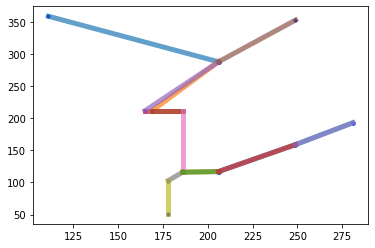

In [ ]:
SHN_image, SHN_keypoints = predict(SHN_model, test_image)
draw_keypoints_on_image(SHN_image, SHN_keypoints)
draw_skeleton_on_image(SHN_image, SHN_keypoints)

array([[[148, 134,  71],
        [152, 138,  75],
        [156, 142,  79],
        ...,
        [ 81,  95,  78],
        [ 82,  95,  77],
        [ 82,  94,  74]],

       [[148, 137,  75],
        [148, 137,  73],
        [149, 138,  74],
        ...,
        [ 81,  95,  78],
        [ 82,  95,  77],
        [ 83,  95,  75]],

       [[146, 136,  74],
        [143, 133,  71],
        [141, 132,  67],
        ...,
        [ 82,  96,  81],
        [ 83,  96,  79],
        [ 83,  94,  77]],

       ...,

       [[210, 233, 187],
        [208, 234, 187],
        [208, 234, 187],
        ...,
        [161, 194, 139],
        [161, 194, 139],
        [160, 193, 138]],

       [[207, 235, 187],
        [207, 235, 187],
        [207, 235, 187],
        ...,
        [161, 194, 139],
        [160, 193, 138],
        [160, 193, 138]],

       [[207, 235, 187],
        [206, 235, 187],
        [207, 236, 188],
        ...,
        [162, 195, 140],
        [161, 194, 139],
        [161, 194, 139]]

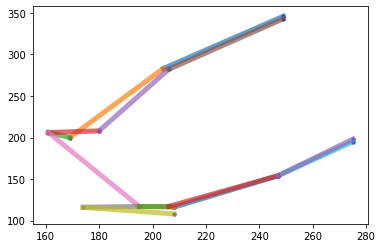

In [ ]:
SBL_image, SBL_keypoints = predict(SBL_model, test_image)
draw_keypoints_on_image(SBL_image, SBL_keypoints)
draw_skeleton_on_image(SBL_image, SBL_keypoints)

In [ ]:
shn_loss_save_path = os.path.join(LOSS_PATH, 'SHN_epoch_5.pkl')

shn_losses = []
with open(shn_loss_save_path, 'rb') as f:
    losses_dict = pickle.load(f)
    #shn_losses.append(losses_dict)

# 훈련 및 검증 손실 추출
shn_train_losses = losses_dict['train_losses']
shn_val_losses = losses_dict['val_losses']

In [ ]:
sbl_losses = []
for filename in os.listdir(LOSS_PATH):
    if filename.startswith("SBL"):
        file_path = os.path.join(LOSS_PATH, filename)
        with open(file_path, 'rb') as f:
            losses_dict = pickle.load(f)
            sbl_losses.append(losses_dict)

In [ ]:
def plot_losses(shn_train_losses, shn_val_losses, sbl_losses):
    epochs = range(1, len(shn_train_losses) + 1)

    # Combine training and validation losses into a single plot
    plt.figure(figsize=(12, 6))

    # Training Loss
    plt.plot(epochs, shn_train_losses, label='SHN Training Loss', marker='o', color='blue')
    plt.plot(epochs, [log.get('loss', 0) for log in sbl_losses], label='SBL Training Loss', marker='o', color='orange', linestyle='dashed')

    # Validation Loss
    plt.plot(epochs, shn_val_losses, label='SHN Validation Loss', marker='o', color='blue', linestyle='dashed')
    plt.plot(epochs, [log.get('val_loss', 0) for log in sbl_losses], label='SBL Validation Loss', marker='o', color='orange', linestyle='dashed')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

- 학습 진행 경과 (loss 감소 현황)

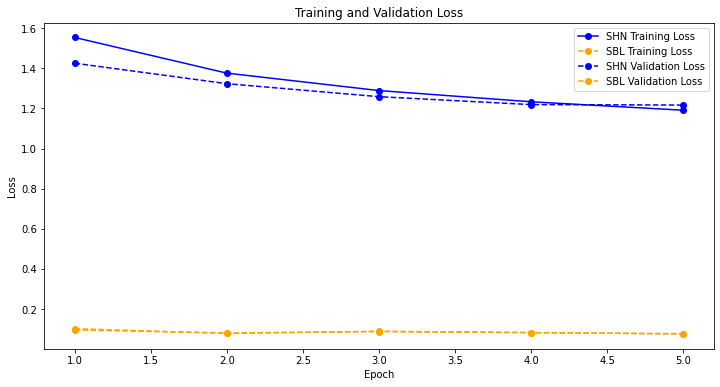

In [ ]:
plot_losses(shn_train_losses, shn_val_losses, sbl_losses)

- SBL Loss가 보이지 않아 bar형으로 다시 만들기

In [ ]:
def bar_losses(shn_train_losses, shn_val_losses, sbl_losses):
    epochs = range(1, len(shn_train_losses) + 1)
    bar_width = 0.35  # Width of the bars

    # Combine training and validation losses into a single plot
    plt.figure(figsize=(12, 6))

    # Training Loss
    shn_train_positions = np.array(epochs) - bar_width/2
    sbl_train_positions = np.array(epochs) - bar_width/2
    plt.bar(shn_train_positions, shn_train_losses, width=bar_width, label='SHN Training Loss', color='blue')
    plt.bar(sbl_train_positions, [log.get('loss', 0) for log in sbl_losses], width=bar_width, label='SBL Training Loss', color='orange')

    # Validation Loss
    shn_val_positions = np.array(epochs) + bar_width/2
    sbl_val_positions = np.array(epochs) + bar_width/2
    plt.bar(shn_val_positions, shn_val_losses, width=bar_width, label='SHN Validation Loss', color='blue', hatch='\\')
    plt.bar(sbl_val_positions, [log.get('val_loss', 0) for log in sbl_losses], width=bar_width, label='SBL Validation Loss', color='orange', hatch='\\')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs, labels=[str(epoch) for epoch in epochs])
    plt.legend()
    plt.show()

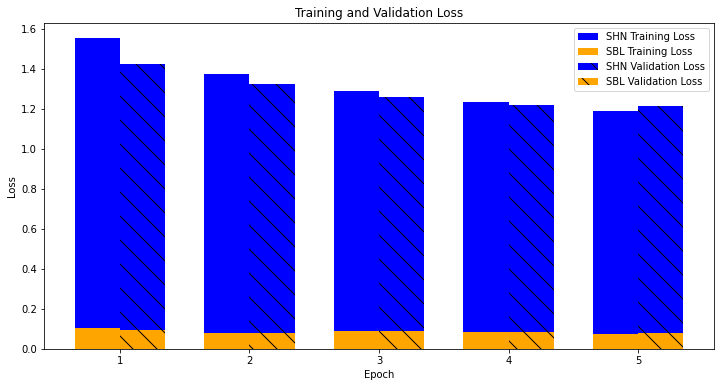

In [ ]:
bar_losses(shn_train_losses, shn_val_losses, sbl_losses)

- Pose Estimation 결과 시각화 (정성적 비교)

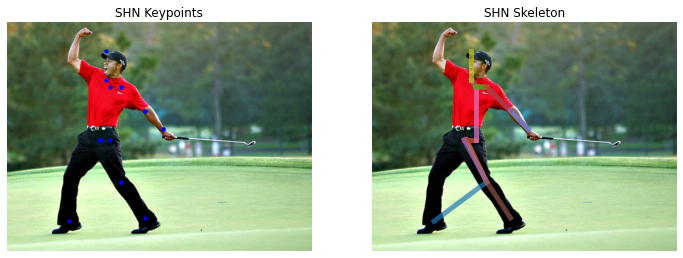

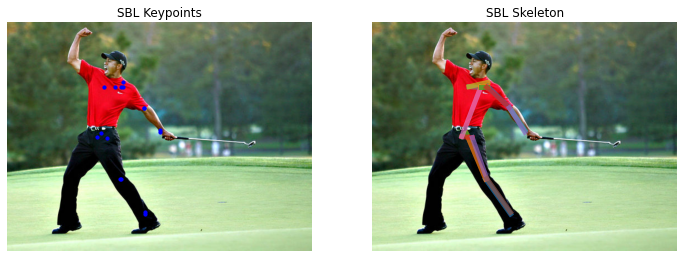

In [ ]:
show_side_by_side_results(SHN_image, SHN_keypoints, SBL_image, SBL_keypoints)

- StackedHourglass 모델은 이미지 처리 과정에서 global feature과 local feature를 고려하여 세밀한 예측을 수행

![image](https://d3s0tskafalll9.cloudfront.net/media/images/17.max-800x600.png)
1. Pooling으로 Global feature 찾기
    - 모델은 이미지를 작게 만들기 위해 pooling과 같은 연산을 사용하여 이미지의 전역 특징을 추출한다.
2. Upsampling으로 Local feature 고려
    - 작게 만들어진 이미지에는 global feature이 들어있는데, 이제 이를 다시 크게 만들어 local feature까지 고려해야 한다.

---
- Simplebaseline 모델은 (x, y)를 직접 regression 하는 방법이 heatmap 기반으로 바뀌고 모델의 구조가 바뀌어 가면서 encoder-decoder가 쌓아져 가는 형태

![image](https://d3s0tskafalll9.cloudfront.net/media/images/19.max-800x600.png)
- backbone으로 ResNet50을 사용하였다.
- ResNet50만 사용한 간단한 구조가 hourglass와 같은 SOTA를 이겼다고 한다.

---
- 시각화 결과를 확인해보면 epoch가 작아서 그런지 두 모델 다 잘 잡지는 못한것같다.
- 그나마 StackedHourglass은 왼쪽 무릎과 오른쪽 발목이 직선으로 연결되어 이상한 뼈대가 만들어졌지만
- Simplebaseline은 keypoint를 잘 못잡았을뿐 keypoint들끼리 잘 연결된 모습이다.

## 회고
- StackedHourglass 모델과 Simplebaseline 모델 구현을 하고 실험을 진행했는데
- StackedHourglass 모델은 train 함수에서 잘 학습을 진행했지만,
- Simplebaseline 모델은 train 함수를 사용하면 멀티 gpu 세팅이 충돌이 발생하여 여러 방법으로 새벽까지 시도를 해보았지만 실험을 진행할 수 없었다.
- 나융 퍼실님이 멀티 gpu 세팅이 충돌로 오류가 날 수 있으니 옵션만 세팅해주고 loss를 비교해보라고 하셔서 model.fit()으로 옵션들만 똑같이 들고와서 Simplebaseline 모델 학습을 진행하였다.